In [1]:
# DEPENDENCIES and DEFAULTS
import math #.....................................Math functionality
import numpy as np #..............................Numpy for working with arrays
import matplotlib.pyplot as plt #.................Plotting functionality 

In [2]:
#VARIABLES FROM PREVIOUS FILE
L = 60.5 #(m) Bridge span
vp = 1.3 #(m/s) Pedestrian walking velocity
tMax = L/vp #(s) Crossing time
m = 80 #(kg) Pedestrian mass
G = 9.81*m #(N) Static weight of pedestrian

fv = 0.35*vp**3 - 1.59*vp**2 + 2.93*vp #(Hz) Pacing frequency
DLF = 0.41*(fv-0.95) #Dynamic load factor

delT = 0.005 #(s) Time-step
time = np.arange(0, tMax+delT, delT) #Time vector
Fv = G + abs(G*DLF*np.sin(2*math.pi*(fv/2)*time)) #Static + Dynamic GRF

In [3]:
def Duhamel(T, F):
    #Initialise a container of zeros to hold the displacement values
    U = np.zeros(len(T))
    
    #Initialise values for the cumulative sum used to calculate A and B at each time-step
    ACum_i=0 
    BCum_i=0
    
    #Cycle through the time vector and evaluate the response at each time point
    for i, t in enumerate(T):
        #Only start calculating on the second iteration (need two values for trapezoidal area calc)
        if i>0:     
            #Calculate A[i] 
            y_i = math.e**(xi*wn*T[i]) * F[i] * math.cos(wd*T[i]) #Value of integrand at current time-step
            y_im1 = math.e**(xi*wn*T[i-1]) * F[i-1] * math.cos(wd*T[i-1]) #Value of integrand at previous time-step
            Area_i = 0.5*delT*(y_i+y_im1) #Area of trapezoid
            ACum_i += Area_i #Cumulative area from t=0 to current time
            A_i = (1/(m*wd))*ACum_i #Value of A for the current time-step
            
            #Calculate B[i] 
            y_i = math.e**(xi*wn*T[i]) * F[i] * math.sin(wd*T[i])
            y_im1 = math.e**(xi*wn*T[i-1]) * F[i-1] * math.sin(wd*T[i-1])
            Area_i = 0.5*delT*(y_i+y_im1)
            BCum_i += Area_i
            B_i = (1/(m*wd))*BCum_i                
                  
            #Calculate the response 
            U[i] = A_i*math.e**(-xi*wn*T[i])*math.sin(wd*T[i]) - B_i * math.e**(-xi*wn*T[i])*math.cos(wd*T[i])             
            
    return U

In [4]:
xp = vp*time #Pedestrian position as a function of time
phi = np.sin(math.pi*xp/L) #Mode shape at pedestrian's location
Fn = Fv*phi #Modal force experienced by SDoF system

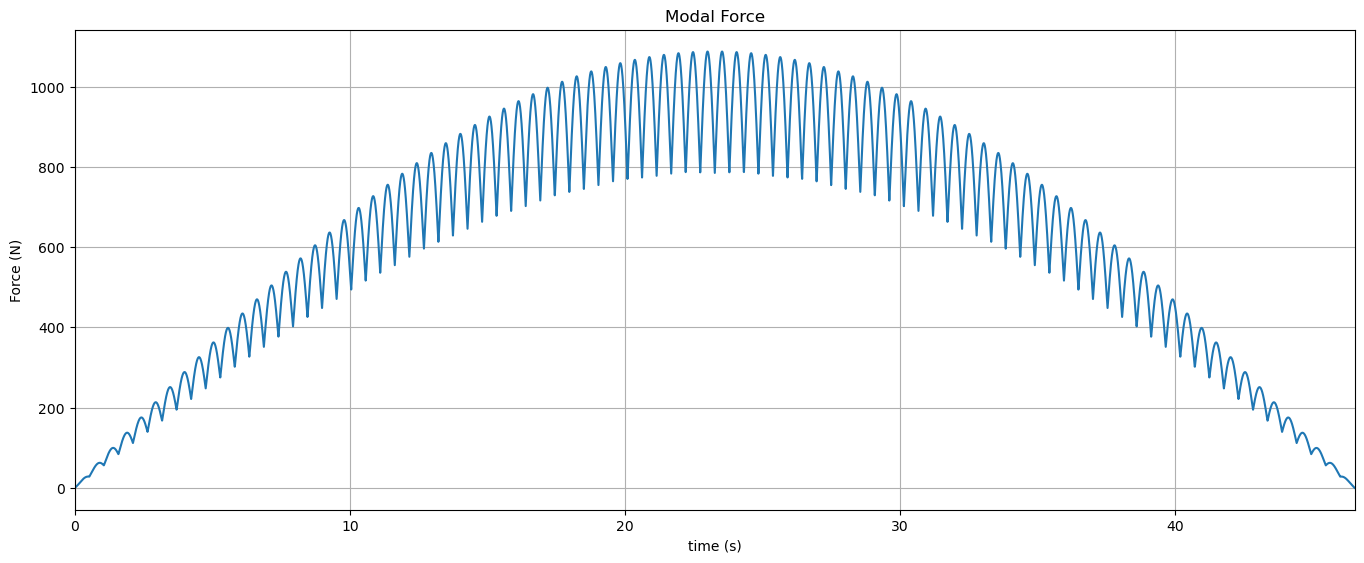

In [6]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,1]) 
axes.plot(time,Fn, '-', label='Modal load')  

axes.set_xlabel('time (s)')
axes.set_ylabel('Force (N)')
axes.set_title('Modal Force')
axes.set_xlim([0,tMax])
plt.grid()
plt.show()

In [7]:
M = 2000 #(kg/m) Mass per unit length]
m = 0.5*M*L #(kg) Modal mass of mode 1
xi = 0.025 #Damping ratio
fn = 2.5 #(Hz) Bridge modal frequency
wn = 2*math.pi*fn #(rads/s) Angular modal frequency
wd = wn*math.sqrt(1-xi**2) #(rads/s) Damped angular modal frequency

In [8]:
response = Duhamel(time, Fn) #Response calculated using the Duhamel integral function

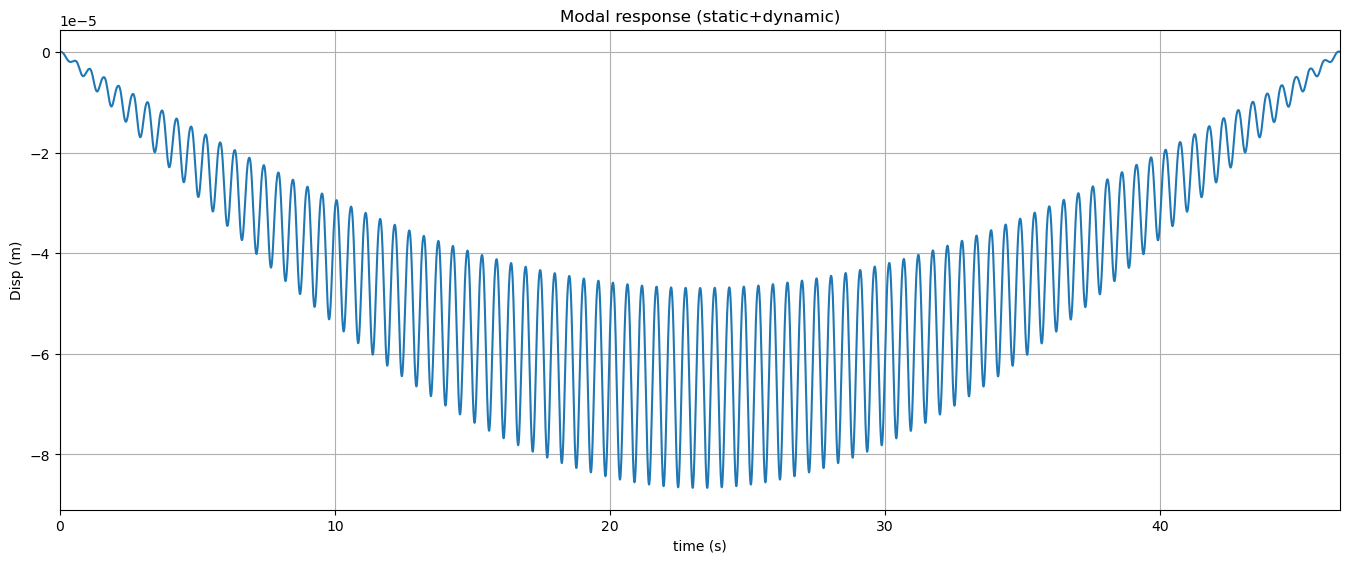

In [10]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,1]) 
axes.plot(time,-response, '-')  

axes.set_xlabel('time (s)')
axes.set_ylabel('Disp (m)')
axes.set_title('Modal response (static+dynamic)')
axes.set_xlim([0,tMax])
plt.grid()
plt.show()

In [11]:
Fn_static = G*phi #Static component of GRF
Fn_dynamic = abs(G*DLF*np.sin(2*math.pi*(fv/2)*time))*phi #Dynamic component of GRF

response_static = Duhamel(time, Fn_static) #Response due to constant magnitude moving load
response_dynanmic = Duhamel(time, Fn_dynamic) #Response due to footsteps (with static load component removed)

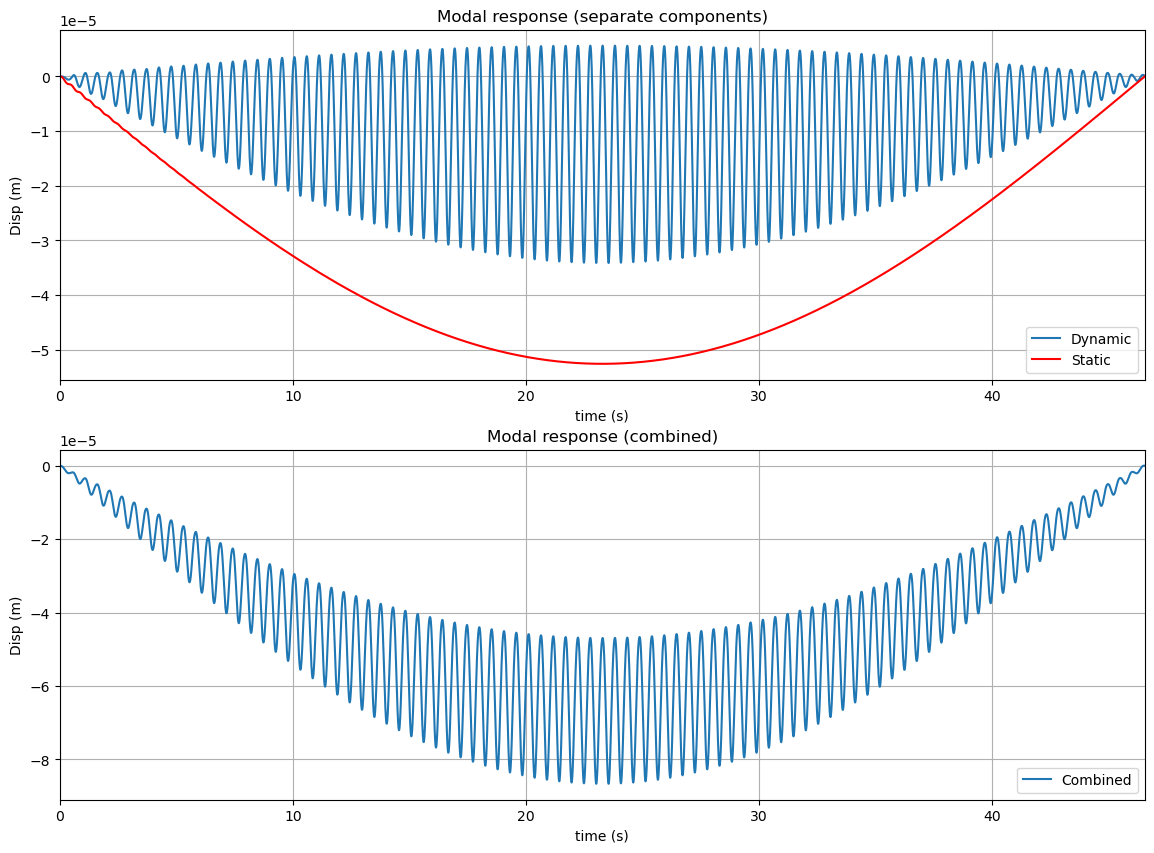

In [12]:
fig, axes = plt.subplots(figsize=(14,10),nrows=2,ncols=1) 
axes[0].plot(time,-response_dynanmic, '-', label='Dynamic')  
axes[0].plot(time,-response_static, 'r-', label='Static') 
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('Disp (m)')
axes[0].set_title('Modal response (separate components)')
axes[0].legend(loc='lower right')
axes[0].set_xlim([0,tMax])
axes[0].grid()

axes[1].plot(time,-response, '-', label='Combined')  
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('Disp (m)')
axes[1].set_title('Modal response (combined)')
axes[1].legend(loc='lower right')
axes[1].set_xlim([0,tMax])
axes[1].grid()

plt.show()

In [13]:
def Peaks(disp, time):
    #Initialise containers to hold peaks and their times
    peaks = np.empty([1,0]) 
    times = np.empty([1,0])
    
    #Calculate slopes for each data point
    slopes = np.zeros(len(disp))
    for i, u in enumerate(disp):
        if(i<len(disp)-1):
            slopes[i] = disp[i+1]-disp[i]
    
    #Cycle through all slopes and pick out peaks
    for i, s in enumerate(slopes):
        if (i<len(slopes)-1):
            if(slopes[i+1]<0 and slopes[i]>0):
                peaks = np.append(peaks,disp[i])
                times = np.append(times,time[i])
                
    return [peaks, times]        

In [14]:
peaks, times = Peaks(response,time)

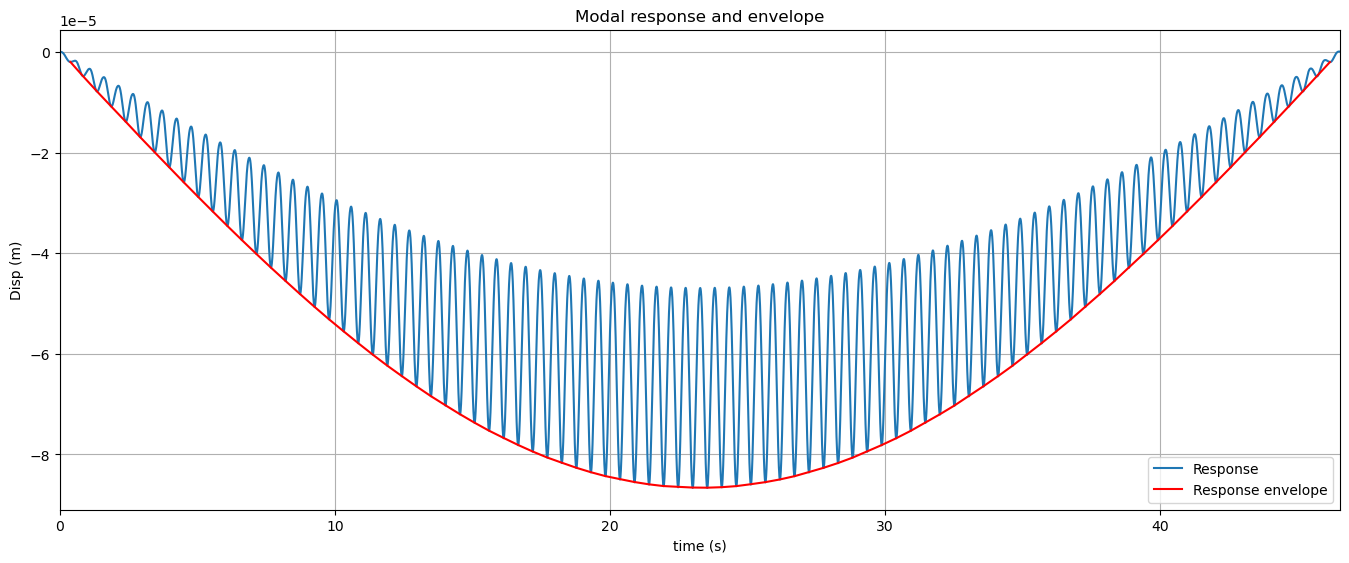

In [15]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,1]) 
axes.plot(time,-response, '-', label='Response')  
axes.plot(times,-peaks,'r-', label='Response envelope')

axes.set_xlabel('time (s)')
axes.set_ylabel('Disp (m)')
axes.set_title('Modal response and envelope')
axes.legend(loc='lower right')
axes.set_xlim([0,tMax])
plt.grid()
plt.show()

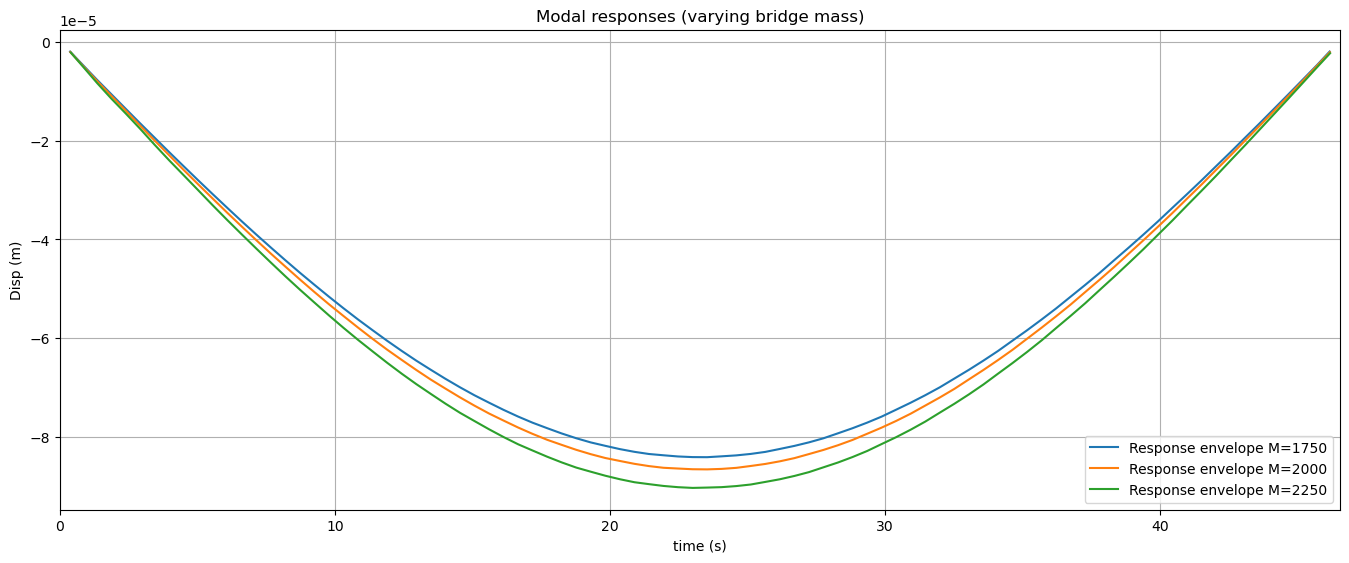

In [16]:
k = m*wn**2 #(N/m) Original system stiffness
Masses = [1750, 2000, 2250] #(kg/m) Masses per unit length to test

fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,1])

for M in Masses:    
    m = 0.5*M*L #(kg) Modal mass of mode 1
    wn = math.sqrt(k/m)
    wd = wn*math.sqrt(1-xi**2) #(rads/s) Damped angular modal frequency
        
    response = Duhamel(time, Fn) #Response calculated using the Duhamel integral function
    peaks, times = Peaks(response,time)
    
#     axes.plot(time,response,'-', label=f'Response M={M}')
    axes.plot(times,-peaks,'-', label=f'Response envelope M={M}')
    
#Housekeeping
axes.set_xlabel('time (s)')
axes.set_ylabel('Disp (m)')
axes.set_title('Modal responses (varying bridge mass)')
axes.legend(loc='lower right')
axes.set_xlim([0,tMax])
plt.grid()
plt.show()